## Dependencies

In [1]:
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import SNAPDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.utils import negative_sampling, to_networkx

torch.manual_seed(0)

%matplotlib notebook

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

orig_transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
])

transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

orig_dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=orig_transform)
dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=transform)

data = orig_dataset[0]
train_data, val_data, test_data = dataset[0]

In [3]:
print(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[2432], edge_label_index=[2, 2432])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[284], edge_label_index=[2, 284])
Data(x=[347, 1406], edge_index=[2, 5148], circle=[325], circle_batch=[325], edge_label=[570], edge_label_index=[2, 570])


## Prediction

In [4]:
from torch import nn
import torch.nn.functional as F


class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.hstack((-out, out)).T


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # TODO: look into SAGEConv, GATConv, GINConv, comparison between
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.W1 = nn.Linear(out_channels * 2, out_channels)
        self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        z1 = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        out1 = self.W2(F.relu(self.W1(z1)).squeeze())
        
        z2 = torch.cat((z[edge_label_index[1]], z[edge_label_index[0]]), dim=1)
        out2 = self.W2(F.relu(self.W1(z2)).squeeze())
        
        return (out1 + out2) / 2
    
    def forward(self, x, edge_index, edge_label_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_label_index)
        return torch.hstack((-out, out)).T

simple_model = SimpleNet(dataset.num_features, 128, 32).to(device)
simple_optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=3e-3)
    
model = Net(dataset.num_features, 128, 32).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: These methods simultaneously use node feature and graph structure properties.
#       Is it possible to train models that look at each aspect separately
#       Can look at only node features by just passing original layer to MLP
#       Unsure if can look at only graph by passing random vector into GCNConv
#       Should also read up on Node2Vec and other methods of generating node embeddings (talk to Rex)

In [5]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, 
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1], 
        method='sparse'
    )
    
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    a, b = data.edge_label.cpu().numpy(), out.cpu().numpy()
    c = (out > 0.5).float().cpu().numpy()
    return roc_auc_score(a, b), accuracy_score(a, c)

In [6]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(simple_model, simple_optimizer, train_data)
    val_auc, val_acc = test(simple_model, val_data)
    test_auc, test_acc = test(simple_model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

simple_z = simple_model.encode(test_data.x, test_data.edge_index)
simple_final_edge_index = simple_model.decode(simple_z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4909, Val: 0.9397 0.8275, Test: 0.8928 0.7456
Epoch: 100, Loss: 0.4780, Val: 0.9504 0.8204, Test: 0.9038 0.7526
Epoch: 150, Loss: 0.4444, Val: 0.9439 0.8134, Test: 0.9073 0.7526
Epoch: 200, Loss: 0.4373, Val: 0.9361 0.8028, Test: 0.9042 0.7526
Epoch: 250, Loss: 0.4314, Val: 0.9233 0.8134, Test: 0.8888 0.7456
Epoch: 300, Loss: 0.4329, Val: 0.9221 0.8345, Test: 0.8867 0.7544
Epoch: 350, Loss: 0.4278, Val: 0.9214 0.8345, Test: 0.8880 0.7561
Epoch: 400, Loss: 0.4221, Val: 0.9181 0.8310, Test: 0.8922 0.7561
Epoch: 450, Loss: 0.4148, Val: 0.9206 0.8486, Test: 0.8860 0.7702
Epoch: 500, Loss: 0.4210, Val: 0.9202 0.8556, Test: 0.8846 0.7632
Epoch: 550, Loss: 0.4126, Val: 0.9152 0.8415, Test: 0.8834 0.7737
Epoch: 600, Loss: 0.4235, Val: 0.9104 0.8380, Test: 0.8777 0.7789
Epoch: 650, Loss: 0.4128, Val: 0.9134 0.8415, Test: 0.8761 0.7702
Epoch: 700, Loss: 0.4192, Val: 0.9081 0.8592, Test: 0.8749 0.7807
Epoch: 750, Loss: 0.3995, Val: 0.9096 0.8521, Test: 0.8780 0.7772
Epoch: 800

In [7]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(model, optimizer, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode(z, test_data.edge_label_index)

Epoch: 050, Loss: 0.3961, Val: 0.9187 0.8486, Test: 0.8935 0.8123
Epoch: 100, Loss: 0.2978, Val: 0.9431 0.8803, Test: 0.9341 0.8649
Epoch: 150, Loss: 0.2693, Val: 0.9488 0.8768, Test: 0.9384 0.8649
Epoch: 200, Loss: 0.2687, Val: 0.9505 0.8908, Test: 0.9371 0.8632
Epoch: 250, Loss: 0.2676, Val: 0.9503 0.8803, Test: 0.9332 0.8614
Epoch: 300, Loss: 0.2662, Val: 0.9521 0.8944, Test: 0.9338 0.8596
Epoch: 350, Loss: 0.2561, Val: 0.9531 0.9014, Test: 0.9340 0.8596
Epoch: 400, Loss: 0.2523, Val: 0.9546 0.8873, Test: 0.9335 0.8579
Epoch: 450, Loss: 0.2607, Val: 0.9577 0.8979, Test: 0.9341 0.8596
Epoch: 500, Loss: 0.2463, Val: 0.9570 0.8838, Test: 0.9336 0.8632
Epoch: 550, Loss: 0.2466, Val: 0.9585 0.9120, Test: 0.9358 0.8596
Epoch: 600, Loss: 0.2321, Val: 0.9584 0.9049, Test: 0.9362 0.8632
Epoch: 650, Loss: 0.2371, Val: 0.9591 0.9014, Test: 0.9378 0.8684
Epoch: 700, Loss: 0.2351, Val: 0.9603 0.9014, Test: 0.9387 0.8702
Epoch: 750, Loss: 0.2349, Val: 0.9589 0.9014, Test: 0.9373 0.8719
Epoch: 800

In [8]:
(test_data.edge_label == (torch.sigmoid(simple_final_edge_index.squeeze()) > 0.7)).sum() / test_data.edge_label.shape[0]

tensor(0.8404)

In [9]:
(test_data.edge_label == (torch.sigmoid(final_edge_index.squeeze()) > 0.5)).sum() / test_data.edge_label.shape[0]

tensor(0.8789)

In [10]:
simple_model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ 0.0684,  1.2058,  0.5227,  ...,  1.2940,  0.2764,  0.4750],
        [-0.0684, -1.2058, -0.5227,  ..., -1.2940, -0.2764, -0.4750]],
       grad_fn=<PermuteBackward0>)

In [11]:
model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[-7.0613, -0.8747, -0.9547,  ...,  1.3285,  8.9529,  8.9489],
        [ 7.0613,  0.8747,  0.9547,  ..., -1.3285, -8.9529, -8.9489]],
       grad_fn=<PermuteBackward0>)

## Exploration

In [12]:
test_data.edge_label_index[:, 5]

tensor([179, 186])

In [13]:
node_1 = 179
node_2 = 186

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {193, 195, 100, 4, 298, 203, 301, 47, 79, 241, 52, 93, 23, 248, 345, 346, 91, 253}
Node 2 Neighbors: {4, 265, 298, 301, 79, 241, 93, 23, 248, 345, 346, 253}
Overlapping Neighbors: {4, 298, 301, 79, 241, 23, 248, 345, 346, 93, 253}


<IPython.core.display.Javascript object>


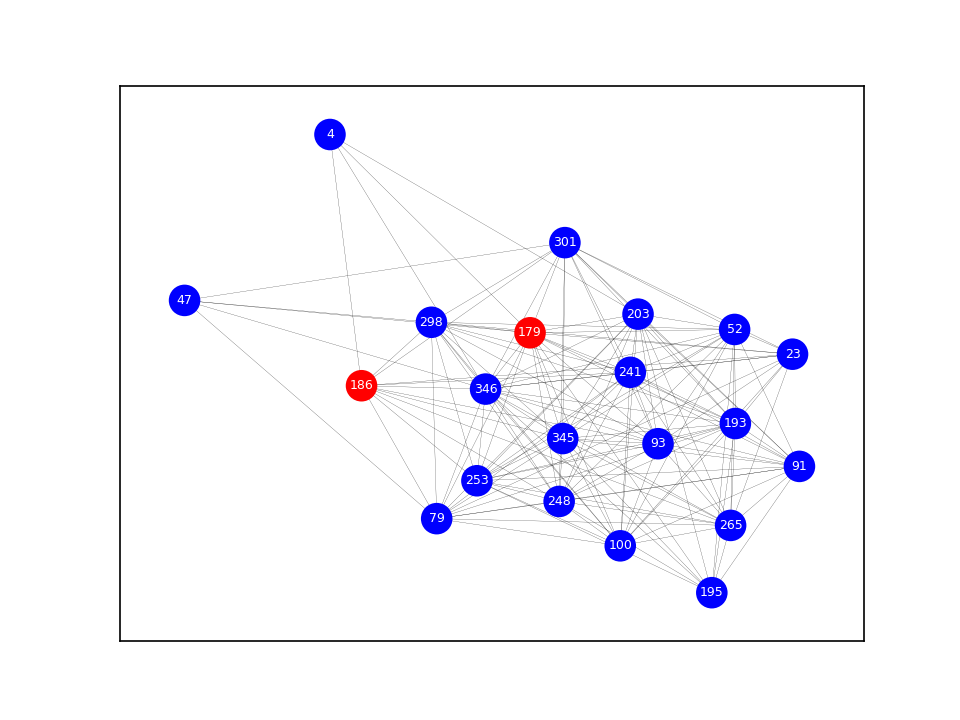

In [14]:
nodes = [node_1, node_2] + list(node_1_neighbors.union(node_2_neighbors))
colors = ["red", "red"] + ["blue" for _ in nodes[2:]]

fig, ax = plt.subplots()
g = to_networkx(test_data, to_undirected=True)
h = g.subgraph(nodes)
nx.draw_networkx(h, node_size=200, nodelist=nodes, node_color=colors, width=0.1, font_color="white", font_size=6)
plt.show()

In [15]:
old_z = model.encode(test_data.x, test_data.edge_index)
old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
print(old_pred)

tensor([1.3618], grad_fn=<DivBackward0>)


In [16]:
for neighbor in node_1_neighbors.union(node_2_neighbors):
    temp_x = test_data.x.clone()
    temp_x[neighbor] = 0
    new_z = model.encode(temp_x, test_data.edge_index)
    new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
    print(neighbor, "\t", round(new_pred.item(), 5))

193 	 1.18723
195 	 1.26495
4 	 1.31428
265 	 1.13241
203 	 1.23557
79 	 1.1781
23 	 1.34098
345 	 1.20555
346 	 1.18653
91 	 1.39301
93 	 1.22382
100 	 1.22159
298 	 1.21286
301 	 1.32216
47 	 1.26612
241 	 1.35333
52 	 1.38024
248 	 1.38417
253 	 1.068


In [17]:
# Start implementing GNNExplainer, PGExplainer, and SubgraphX architectures with 1-hop subgraph as parameters
# Think about separately learning node feature explanations

## GNNExplainer

In [18]:
from math import sqrt

from torch_geometric.nn import GNNExplainer
from torch_geometric.nn.models.explainer import clear_masks, set_masks
from torch_geometric.utils import k_hop_subgraph

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    coeffs = {
        'edge_size': 6,  # 0.005
        'edge_reduction': 'mean',  # sum
        'node_feat_size': 0.0,  # 1.0
        'node_feat_reduction': 'mean',  # mean
        'edge_ent': 1.0,  # 1.0
        'node_feat_ent': 0.0,  # 0.1
    }
    
    def _initialize_masks(self, x, edge_index, sub_edge_mask=None, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1

        # NOTE: disabled feature masking
        # if self.feat_mask_type == 'individual_feature':
        #     self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        # elif self.feat_mask_type == 'scalar':
        #     self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        # else:
        #     self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)
        self.node_feat_mask = torch.nn.Parameter(100 * torch.ones(1, F))
        
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            if sub_edge_mask is None:
                self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)
            else:
                E_1, mask = sub_edge_mask.sum(), 100 * torch.ones(E)
                mask[sub_edge_mask] = torch.randn(E_1) * std
                self.edge_mask = torch.nn.Parameter(mask)
            
    def _loss(self, log_logits, prediction, node_idx = None):
        """
        if self.return_type == 'regression':
            if node_idx is not None and node_idx.min() >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx.min() >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
                print(loss)
            else:
                loss = -log_logits[0, prediction[0]]
        """

        error_loss = -log_logits[prediction]
                
        if self.allow_edge_mask:
            m = self.edge_mask[self.sub_edge_mask].sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            edge_size_loss = edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            edge_ent_loss = ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        node_size_loss = node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        node_ent_loss = ent.mean()

        loss = (
            error_loss + 
            self.coeffs['edge_size'] * edge_size_loss + 
            self.coeffs['edge_ent'] * edge_ent_loss +
            self.coeffs['node_feat_size'] * node_size_loss +
            self.coeffs['node_feat_ent'] * node_ent_loss
        )
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    
    def subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        subset_1, edge_index_1, _, edge_mask_1 = k_hop_subgraph(
            node_idx_1, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        subset_2, edge_index_2, _, edge_mask_2 = k_hop_subgraph(
            node_idx_2, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        # Combines two node-centered subgraphs
        temp_node_idx = edge_index[0].new_full((num_nodes,), -1)  # full size
        edge_mask = edge_mask_1 | edge_mask_2
        edge_index = edge_index[:, edge_mask]  # filters out edges
        subset = torch.cat((subset_1, subset_2)).unique()
        temp_node_idx[subset] = torch.arange(subset.size(0), device=edge_index.device)
        edge_index = temp_node_idx[edge_index]  # maps edge_index to [0, n]
        x = x[subset]  # filters out nodes
        mapping = torch.tensor([
            (subset == node_idx_1).nonzero().item(), 
            (subset == node_idx_2).nonzero().item(),
        ])
        
        # NOTE: only optimizes the edges from neighbors to node_1/node_2, ideally enforce in = out (undirected)
        edge_mask_1 = (edge_index[1] == mapping[0])  # .any(dim=0)
        edge_mask_2 = (edge_index[1] == mapping[1])  # .any(dim=0)
        
        sub_edge_mask = edge_mask_1 | edge_mask_2
        
        return x, edge_index, mapping, edge_mask, subset, sub_edge_mask
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)
        
        # Only operate on a k-hop subgraph around `node_idx_1` and `node_idx_2.
        x, edge_index, mapping, hard_edge_mask, subset, sub_edge_mask = \
            self.subgraph(node_idx_1, node_idx_2, x, edge_index)
        self.sub_edge_mask = sub_edge_mask
        
        temp_edge_label_index=mapping.unsqueeze(1)
        
        # Get the initial prediction
        # NOTE: currently prediction is the link prediction confidence. 
        #       Should explore/think about the predictions being each node embedding
        prediction = self.get_initial_prediction(x, edge_index, edge_label_index=temp_edge_label_index)
        
        self._initialize_masks(x, edge_index, sub_edge_mask)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
            # NOTE: disabled feature masking
            # parameters = [self.node_feat_mask, self.edge_mask]
            parameters = [self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        # NOTE: disabled logging
        # if self.log:  # pragma: no cover
        #     pbar = tqdm(total=self.epochs)
        #     pbar.set_description(f'Explain edge ({node_idx_1}, {node_idx_2})')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, edge_label_index=temp_edge_label_index)
            loss = self.get_loss(out, prediction, mapping).mean()
            loss.backward()
            optimizer.step()

            # if self.log:  # pragma: no cover
            #     pbar.update(1)

        # if self.log:  # pragma: no cover
        #     pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

In [19]:
x = test_data.x
edge_index = test_data.edge_index

node_idx_1 = node_1  # test_data.edge_label_index[0, 0].item()
node_idx_2 = node_2  # test_data.edge_label_index[1, 0].item()

print(node_idx_1, node_idx_2)

explainer = EdgeGNNExplainer(model, epochs=200, lr=0.1)
node_feat_mask, edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

print("Done!")

179 186
1.7355   	 0.4962   	 0.6925   	 5.4055   	
1.5988   	 0.4913   	 0.6909   	 5.2372   	
1.6032   	 0.4904   	 0.6886   	 5.2342   	
1.6038   	 0.4924   	 0.6865   	 5.2447   	
1.5354   	 0.4976   	 0.6869   	 5.2077   	
1.4793   	 0.5034   	 0.6871   	 5.1866   	
1.4199   	 0.5097   	 0.6869   	 5.165   	
1.3621   	 0.5164   	 0.6863   	 5.147   	
1.3017   	 0.5235   	 0.6852   	 5.1282   	


C:\Users\Abhijit\AppData\Local\Temp\ipykernel_20236\81617139.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  return torch.hstack((-out, out)).T


1.2655   	 0.5309   	 0.6835   	 5.1344   	
1.2011   	 0.536   	 0.681   	 5.0978   	
1.1652   	 0.5392   	 0.6779   	 5.0784   	
1.1312   	 0.543   	 0.6745   	 5.0636   	
1.0967   	 0.5473   	 0.6709   	 5.0516   	
1.0566   	 0.5522   	 0.667   	 5.0371   	
1.0197   	 0.5576   	 0.663   	 5.0284   	
0.954   	 0.5641   	 0.6598   	 4.9987   	
0.8942   	 0.5709   	 0.6563   	 4.9759   	
0.834   	 0.5779   	 0.6524   	 4.9536   	
0.7756   	 0.5849   	 0.6481   	 4.9332   	
0.7194   	 0.592   	 0.6434   	 4.9151   	
0.6632   	 0.5992   	 0.6383   	 4.8964   	
0.6151   	 0.6062   	 0.6328   	 4.8853   	
0.5602   	 0.6116   	 0.6269   	 4.857   	
0.5131   	 0.6171   	 0.6208   	 4.8366   	
0.4656   	 0.6227   	 0.6143   	 4.8159   	
0.4179   	 0.6282   	 0.6076   	 4.795   	
0.3706   	 0.6338   	 0.6007   	 4.7743   	
0.3239   	 0.6395   	 0.5935   	 4.7546   	
0.2769   	 0.6453   	 0.5862   	 4.7349   	
0.2289   	 0.6513   	 0.5787   	 4.7154   	
0.1792   	 0.6574   	 0.5711   	 4.6949   

-1.1312   	 0.828   	 0.0468   	 3.8833   	
-1.1316   	 0.828   	 0.0464   	 3.8828   	
-1.1318   	 0.828   	 0.046   	 3.8824   	
-1.1321   	 0.8281   	 0.0456   	 3.8819   	
Done!


In [20]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_2)], edge_mask[(edge_index[1] == node_idx_2)])
).T

tensor([[2.3000e+01, 9.9629e-01],
        [4.0000e+00, 9.9516e-01],
        [9.3000e+01, 9.9694e-01],
        [7.9000e+01, 9.9449e-01],
        [3.0100e+02, 9.9310e-01],
        [2.5300e+02, 9.9611e-01],
        [3.4600e+02, 3.9683e-03],
        [2.4100e+02, 9.9389e-01],
        [2.6500e+02, 9.9701e-01],
        [2.4800e+02, 9.9126e-01],
        [3.4500e+02, 9.9585e-01],
        [2.9800e+02, 9.9476e-01]])

In [21]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_1)], edge_mask[(edge_index[1] == node_idx_1)])
).T

tensor([[4.7000e+01, 9.9564e-01],
        [1.0000e+02, 9.9167e-01],
        [2.3000e+01, 9.9388e-01],
        [7.9000e+01, 9.9127e-01],
        [5.2000e+01, 1.1065e-02],
        [4.0000e+00, 9.9563e-01],
        [9.3000e+01, 3.9578e-03],
        [9.1000e+01, 9.8909e-01],
        [3.4500e+02, 9.8812e-01],
        [1.9500e+02, 9.9259e-01],
        [2.4100e+02, 9.7442e-01],
        [2.0300e+02, 9.8774e-01],
        [2.9800e+02, 9.9422e-01],
        [3.0100e+02, 7.6933e-03],
        [2.5300e+02, 9.9049e-01],
        [1.9300e+02, 9.9253e-01],
        [3.4600e+02, 1.4970e-02],
        [2.4800e+02, 9.7967e-01]])

In [22]:
# Thoughts
# - GNNExplainer is very sensitive to loss parameters, either reduces size of explanation but incorrect or correct but full
# - So far, only removing edges with high degree, but not really finding a small subset of influential edges
# - Maybe can experiment with combining loss terms in a different way
# - Can also look at individually explaining the node embeddings for the regression task (similar to V3 notebook)
# - Can look into SubgraphX as starting point of an alternative method (slow)
# - Can also explore fixing directed edge masks to enforce undirected constraint
#    - https://github.com/GraphFramEx/graphframex/blob/main/code/explainer/gnnexplainer.py
#    - Looks like above implements GNNExplainer without using self.edge_mask, might be useful